# Peer-graded Assignment: Segmenting and Clustering Neighbourhoods Toronto

In [1]:
#!conda install -c conda-forge folium=0.5.0

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


In [3]:
!wget -q -O 'toronto_info' https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
print('Data downloaded!')

Data downloaded!


In [4]:
# !conda install -c anaconda beautifulsoup4

## Pulls data from Wikipedia and puts into a dataframe

In [5]:
import requests
import lxml.html as lh
import pandas as pd

In [6]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

In [7]:
#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [8]:
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()

    col.append((name,[]))


In [9]:
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

In [10]:
[len(C) for (title,C) in col]

[288, 288, 288]

In [11]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)



In [12]:
df.head()

,Borough,Neighbourhood,Postcode
0,Not assigned,Not assigned\n,M1A
1,Not assigned,Not assigned\n,M2A
2,North York,Parkwoods\n,M3A
3,North York,Victoria Village\n,M4A
4,Downtown Toronto,Harbourfront\n,M5A


In [13]:
df.rename(columns={'Neighbourhood\n' : 'Neighbourhood'},inplace = True)

In [14]:
list(df)

['Borough', 'Neighbourhood', 'Postcode']

In [15]:
df['Neighbourhood']  = df['Neighbourhood'].str.replace('\n','')


In [16]:
df.head()

,Borough,Neighbourhood,Postcode
0,Not assigned,Not assigned,M1A
1,Not assigned,Not assigned,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A


### drop any rows with 'Not assigned' Borough

In [17]:
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)

In [18]:
df.head()

,Borough,Neighbourhood,Postcode
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A
5,Downtown Toronto,Regent Park,M5A
6,North York,Lawrence Heights,M6A


### Replace not assigned Neighburhoods with Borough Name

In [19]:
df['Neighbourhood'] = df['Neighbourhood'].replace('Not assigned',df['Borough'])
df.head()

,Borough,Neighbourhood,Postcode
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,Harbourfront,M5A
5,Downtown Toronto,Regent Park,M5A
6,North York,Lawrence Heights,M6A


### Gets unique postal codes and creates list of neighbourhoods where there are mutliple

In [20]:
toronto_data = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index()
toronto_data.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Adds lats and longs

In [21]:
toronto_latlongs = pd.read_csv('http://cocl.us/Geospatial_data')
print('Data downloaded!') 

Data downloaded!


In [22]:
toronto_latlongs.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [23]:
toronto = pd.merge(toronto_data, toronto_latlongs, how='left', left_on=('Postcode'), right_on=('Postal Code'))
toronto.head()

,Postcode,Borough,Neighbourhood,Postal Code,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",M1B,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",M1C,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",M1E,43.763573,-79.188711
3,M1G,Scarborough,Woburn,M1G,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,M1H,43.773136,-79.239476


In [24]:
toronto.drop(columns='Postal Code', inplace=True)

In [25]:
toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [26]:
toronto.shape

(103, 5)

### Data Prep COMPLETE!

# Segmentation and Clustering
## Similar to New York exercise - cluster the neighborhoods

In [27]:
CLIENT_ID = 'ESF4ZTQWDK4M0KWFYBLHFZEOZSJBRVX0JOC42VPIH3GDDV0H' # your Foursquare ID
CLIENT_SECRET = 'NFLTJE3UEMHFIRCZPIARJT2TDI2OBT5OLUZIXVOVPHZWEX3O' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ESF4ZTQWDK4M0KWFYBLHFZEOZSJBRVX0JOC42VPIH3GDDV0H
CLIENT_SECRET:NFLTJE3UEMHFIRCZPIARJT2TDI2OBT5OLUZIXVOVPHZWEX3O


In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
# type your answer here

toronto_venues = getNearbyVenues(names=toronto['Neighbourhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )


Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [32]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motel,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,River,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0

In [35]:
toronto_grouped.shape

(100, 276)

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Thai Restaurant,Café,Bar,Steakhouse,Burger Joint,Gym,Sushi Restaurant,Hotel,Restaurant
1,Agincourt,Lounge,Sandwich Place,Skating Rink,Breakfast Spot,Chinese Restaurant,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Dog Run
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Playground,Park,Women's Store,Doner Restaurant,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Pharmacy,Fried Chicken Joint,Pizza Place,Sandwich Place,Beer Store,Fast Food Restaurant,Coffee Shop,German Restaurant,Cupcake Shop
4,"Alderwood, Long Branch",Pizza Place,Gym,Athletics & Sports,Pharmacy,Pool,Pub,Dance Studio,Sandwich Place,Skating Rink,Coffee Shop


In [38]:
neighborhoods_venues_sorted.shape

(100, 11)

In [39]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [40]:
toronto.rename(columns={'Neighbourhood': 'Neighborhood'}, inplace = True)
toronto.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [41]:
# # add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto

# # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3.0,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Bar,Construction & Landscaping,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Women's Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Intersection,Rental Car Location,Pizza Place,Spa,Mexican Restaurant,Breakfast Spot,Medical Center,Discount Store,Dim Sum Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Indian Restaurant,Korean Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Athletics & Sports,Fried Chicken Joint,Hakka Restaurant,Bakery,Thai Restaurant,Bank,Caribbean Restaurant,Dog Run,Dim Sum Restaurant,Diner


## Remove missing data

In [42]:
toronto_merged.drop(toronto_merged[toronto_merged.Postcode == 'M1X'].index, inplace=True)
toronto_merged.drop(toronto_merged[toronto_merged.Postcode == 'M9A'].index, inplace=True)
toronto_merged.drop(toronto_merged[toronto_merged.Postcode == 'M2M'].index, inplace=True)

toronto_merged



,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3.0,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Bar,Construction & Landscaping,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Women's Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Electronics Store,Intersection,Rental Car Location,Pizza Place,Spa,Mexican Restaurant,Breakfast Spot,Medical Center,Discount Store,Dim Sum Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Indian Restaurant,Korean Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Athletics & Sports,Fried Chicken Joint,Hakka Restaurant,Bakery,Thai Restaurant,Bank,Caribbean Restaurant,Dog Run,Dim Sum Restaurant,Diner
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1.0,Playground,Women's Store,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,0.0,Discount Store,Convenience Store,Department Store,Bus Station,Coffee Shop,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,0.0,Bus Line,Bakery,Soccer Field,Park,Intersection,Fast Food Restaurant,Metro Station,Dog Run,Diner,Discount Store
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,0.0,Motel,Movie Theater,American Restaurant,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,0.0,General Entertainment,College Stadium,Café,Skating Rink,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


In [43]:
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(np.int64)

In [44]:
toronto_merged.head()

,Postcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,3,Fast Food Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0,Bar,Construction & Landscaping,Drugstore,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Women's Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0,Electronics Store,Intersection,Rental Car Location,Pizza Place,Spa,Mexican Restaurant,Breakfast Spot,Medical Center,Discount Store,Dim Sum Restaurant
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Indian Restaurant,Korean Restaurant,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0,Athletics & Sports,Fried Chicken Joint,Hakka Restaurant,Bakery,Thai Restaurant,Bank,Caribbean Restaurant,Dog Run,Dim Sum Restaurant,Diner


# Represent Visually

In [45]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Screengrab below as folium does not show up in Github

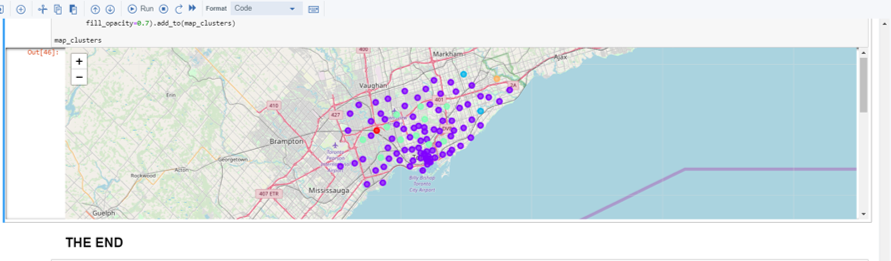

# THE END